In [104]:
import pandas as pd
import matplotlib.pyplot as plt

In [110]:
train_df = pd.read_json("DATASET/train.json")
test_df = pd.read_json("DATASET/test.json")

train_df.columns = ["label","image_path"]
test_df.columns = ["label","image_path"]

train_df.head(5)

,label,image_path
0,1,train/353042_4-IMG005x014-1.JPG
1,1,train/353042_4-IMG005x015-1.JPG
2,1,train/353042_4-IMG006x010-1.JPG
3,1,train/353042_4-IMG007x011-1.JPG
4,1,train/353042_4-IMG007x015-1.JPG


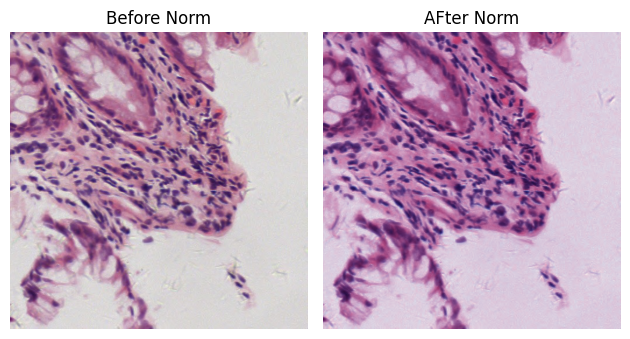

In [146]:
import torchstain
import numpy as np
from PIL import Image

# read target
target = np.array(Image.open("DATASET/train/543716-IMG013x011-2.JPG"))
normalizer = torchstain.normalizers.MacenkoNormalizer(backend='numpy')
normalizer.fit(target)


# normalize image
img = np.array(Image.open("DATASET/train/353042_4-IMG008x014-0.JPG"))
norm, H, E = normalizer.normalize(img)

plt.subplot(121)
plt.title("Before Norm")
plt.imshow(img)
plt.axis("off")

plt.subplot(122)
plt.imshow(norm)
plt.axis("off")
plt.title("AFter Norm")

plt.tight_layout()
plt.show()
plt.close()

#DATASET/train/543716-IMG014x012-2.JPG
#DATASET/train/543645_2-IMG007x013-3.JPG
#DATASET/train/543645_2-IMG023x004-1.JPG
#353042_4-IMG008x014-0.JPG

In [ ]:
import torchstain
import numpy as np
from PIL import Image
import os

def normalize(df, out_root, target_image):

    new_paths = []
    normalizer = torchstain.normalizers.MacenkoNormalizer(backend="numpy")
    normalizer.fit(np.array(Image.open(target_image)))
    os.makedirs(out_root, exist_ok=True)

    for path in df["image_path"]:
        img = np.array(Image.open(os.path.join("DATASET",path)))
        norm, _, _ = normalizer.normalize(img)

        filename = os.path.basename(path)
        save_path = os.path.join(out_root, filename)
        Image.fromarray(norm).save(save_path)
        new_paths.append(save_path)

    df["stain_path"] = new_paths


normalize(train_df, "DATASET_STAIN_NORMALIZED/train", "DATASET/train/543716-IMG013x011-2.JPG")
normalize(test_df,  "DATASET_STAIN_NORMALIZED/test", "DATASET/train/543716-IMG013x011-2.JPG")

In [102]:
train_df.to_csv("DATASET_STAIN_NORMALIZED/train.csv")
test_df.to_csv("DATASET_STAIN_NORMALIZED/test.csv")

In [6]:
train_df = pd.read_csv("DATASET_STAIN_NORMALIZED/train.csv")
test_df = pd.read_csv("DATASET_STAIN_NORMALIZED/train.csv")

In [121]:
import cv2
import os


def preprocess(df, out_root):

    new_paths = []
    os.makedirs(out_root, exist_ok=True)

    for path in df["stain_path"]:
        img = cv2.imread(path)

        # ----- light preprocessing -----
        img = cv2.GaussianBlur(img, (3, 3), 0)
        img = cv2.medianBlur(img, 3)
        img = cv2.bilateralFilter(img, d=5, sigmaColor=50, sigmaSpace=50)
        img = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)

        # CLAHE (LAB)
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        L, A, B = cv2.split(lab)

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        L2 = clahe.apply(L)

        lab = cv2.merge((L2, A, B))
        img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

        filename = os.path.basename(path)
        save_path = os.path.join(out_root, filename)
        cv2.imwrite(save_path, img)
        new_paths.append(save_path)

    df["final_path"] = new_paths

preprocess(train_df,"DATASET_NORMALIZED/train")
preprocess(test_df,"DATASET_NORMALIZED/test")

In [123]:
train_df.to_csv("DATASET_NORMALIZED/train.csv")
test_df.to_csv("DATASET_NORMALIZED/test.csv")

In [124]:
from torch.utils.data import Dataset
from PIL import Image
import os

class MyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root = root_dir
        self.transform = transform
        self.files = os.listdir(root_dir)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):

        img_path = os.path.join(self.root, self.files[idx])
        img = Image.open(img_path).convert("RGB")
        label = int(self.files[idx].split(".")[0][-1])
        
        if self.transform:
            img = self.transform(img)

        return img,label

In [125]:
from torchvision import transforms

temp_transform = transforms.Compose([    
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

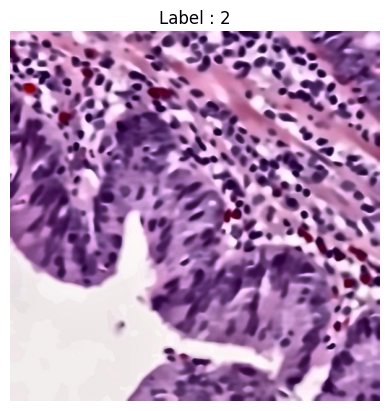

In [122]:
import random

temp_dataloader = MyDataset("DATASET_NORMALIZED/train")
random_idx = random.randint(0, len(temp_dataloader) - 1)
img, label = temp_dataloader.__getitem__(random_idx)

plt.axis("off")
plt.title(f"Label : {label}")
plt.imshow(img)
plt.show()

In [126]:
def get_mean_std(loader):

    mean = 0
    std = 0
    total_images = 0

    for images,_ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples,images.size(1), -1)

        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples

    mean /= total_images
    std /= total_images

    return mean.tolist(),std.tolist()

In [127]:
from torch.utils.data import DataLoader

temp_train = MyDataset("DATASET_NORMALIZED/train",transform=temp_transform)
temp_test = MyDataset("DATASET_NORMALIZED/test", transform=temp_transform)

temp_train_loader = DataLoader(
    temp_train,
    batch_size=512,
    num_workers=0,
    shuffle=False
)

temp_test_loader = DataLoader(
    temp_test,
    batch_size=512,
    num_workers=0,
    shuffle=False
)

train_mean, train_std = get_mean_std(temp_train_loader)
test_mean, test_std = get_mean_std(temp_test_loader)

print(train_mean, train_std)
print(test_mean,test_std)

[0.6943547129631042, 0.5278080105781555, 0.6968717575073242] [0.21741050481796265, 0.24476808309555054, 0.20546939969062805]
[0.7039154767990112, 0.543766975402832, 0.7036891579627991] [0.21847818791866302, 0.25061747431755066, 0.20683082938194275]


In [128]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomApply([
        transforms.RandomHorizontalFlip()
    ],p = 0.7),
    transforms.RandomApply([
        transforms.RandomRotation(50)
    ],p = 0.7),
    transforms.RandomApply([
        transforms.ColorJitter(
            brightness = 0.2,
            contrast = 0.2,
            saturation = 0.1,
            hue = 0.05,
        ),
    ], p =0.5),
    transforms.RandomApply([
        transforms.GaussianBlur(3)
    ], p=0.4),
    transforms.ToTensor(),
    transforms.Normalize(train_mean,train_std)
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(test_mean,test_std)
])

In [129]:
train_dataset = MyDataset("DATASET/train", transform=train_transform)
test_dataset = MyDataset("DATASET/test", transform=test_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=0
)

In [130]:
import torch.nn as nn
import torch

from torch import Tensor
from typing import Type


class BasicBlock(nn.Module):
    def __init__(self,in_channels: int,out_channels: int, stride: int = 1, expansion: int = 1, downsample: nn.Module = None,) -> None:
        
        super().__init__()
        self.expansion = expansion
        self.downsample = downsample
        
        self.conv1 = nn.Conv2d( in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d( out_channels, out_channels * self.expansion, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x: Tensor) -> Tensor:
        
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        
        return out


class ResNet(nn.Module):
    def __init__( self, img_channels: int, num_layers: int, block: Type[BasicBlock], num_classes: int = 4) -> None:
        super().__init__()
        
        layers = [2, 2, 2, 2]
        self.expansion = 1

        self.in_channels = 64
        # All ResNets (18 to 152) contain a Conv2d => BN => ReLU for the first
        # three layers. Here, kernel size is 7.
        self.conv1 = nn.Conv2d( in_channels=img_channels, out_channels=self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)

    def _make_layer( self, block: Type[BasicBlock], out_channels: int, blocks: int, stride: int = 1) -> nn.Sequential:
        
        downsample = None
        
        if stride != 1:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    out_channels * self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )
        layers = []
        layers.append( block(self.in_channels, out_channels, stride, self.expansion, downsample))
        self.in_channels = out_channels * self.expansion

        for i in range(1, blocks):
            layers.append(block(self.in_channels, out_channels, expansion=self.expansion))
        
        return nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        
        op_conv1 = self.conv1(x)
        op_bn1 = self.bn1(op_conv1)
        op_relu = self.relu(op_bn1)
        op_maxpool = self.maxpool(op_relu)

        op_layer1 = self.layer1(op_maxpool)
        op_layer2 = self.layer2(op_layer1)
        op_layer3 = self.layer3(op_layer2)
        op_layer4 = self.layer4(op_layer3)

        op_avgpool = self.avgpool(op_layer4)
        x = torch.flatten(op_avgpool, 1)
        x = self.fc(x)

        return op_conv1,op_bn1,op_relu,op_maxpool,op_layer1,op_layer2,op_layer3,op_layer4,op_avgpool,x


if __name__ == "__main__":
    tensor = torch.rand([1, 3, 224, 224])
    model = ResNet(img_channels=3, num_layers=18, block=BasicBlock, num_classes=4)
    output = model(tensor)

In [131]:
from torchinfo import summary
summary(model, input_size=(128, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 64, 16, 16]         --
├─Conv2d: 1-1                            [128, 64, 16, 16]         9,408
├─BatchNorm2d: 1-2                       [128, 64, 16, 16]         128
├─ReLU: 1-3                              [128, 64, 16, 16]         --
├─MaxPool2d: 1-4                         [128, 64, 8, 8]           --
├─Sequential: 1-5                        [128, 64, 8, 8]           --
│    └─BasicBlock: 2-1                   [128, 64, 8, 8]           --
│    │    └─Conv2d: 3-1                  [128, 64, 8, 8]           36,864
│    │    └─BatchNorm2d: 3-2             [128, 64, 8, 8]           128
│    │    └─ReLU: 3-3                    [128, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                  [128, 64, 8, 8]           36,864
│    │    └─BatchNorm2d: 3-5             [128, 64, 8, 8]           128
│    │    └─ReLU: 3-6                    [128, 64, 8, 8]           --
│

In [132]:
def clear_gpu():
    import gc, torch
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

In [133]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def save_feature_maps(feat, save_dir, layer_name, channels=[0,1,2,3,4,5]):
    """
    feat: [B, C, H, W] tensor
    Saves selected channels as PNG images.
    """
    os.makedirs(save_dir, exist_ok=True)

    fmap = feat[0].cpu()  # use sample 0

    for c in channels:
        fmap_c = fmap[c].detach().numpy()
        plt.imshow(fmap_c, cmap="viridis")
        plt.axis("off")
        plt.savefig(
            os.path.join(save_dir, f"{layer_name}_ch{c}.png"),
            bbox_inches='tight',
            pad_inches=0
        )
        plt.close()


def evaluate(model, loader, criterion, device):
    """
    Returns val_loss and val_accuracy for the epoch.
    """
    model.eval()
    total, correct, running_loss = 0, 0, 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            *_, logits = outputs  # last output = model predictions

            loss = criterion(logits, labels)
            running_loss += loss.item() * imgs.size(0)

            _, preds = torch.max(logits, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / total
    val_acc = correct / total * 100
    return val_loss, val_acc


def train_full(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=10):

    model = model.to(device)

    save_root = "INTERMEDIATE_LAYER_IMAGES"
    os.makedirs(save_root, exist_ok=True)

    layer_names = [
        "conv1", "bn1", "relu", "maxpool",
        "layer1", "layer2", "layer3", "layer4", "avgpool"
    ]

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 50)

        epoch_path = os.path.join(save_root, f"epoch_{epoch+1}")
        os.makedirs(epoch_path, exist_ok=True)

        # ---------------- TRAIN ----------------
        model.train()
        running_loss, correct, total = 0, 0, 0

        for batch_idx, (imgs, labels) in enumerate(tqdm(train_loader)):

            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(imgs)
            *intermediates, logits = outputs

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            clear_gpu()

            # stats
            running_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(logits, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # save intermediate feature images (ONLY batch 0)
            if batch_idx == 0:
                batch_path = os.path.join(epoch_path, "batch_0")
                os.makedirs(batch_path, exist_ok=True)

                for name, feat in zip(layer_names, intermediates):
                    layer_dir = os.path.join(batch_path, name)
                    save_feature_maps(feat, layer_dir, name)

        train_loss = running_loss / total
        train_acc = 100 * correct / total

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")

        # ---------------- EVALUATE ----------------
        val_loss, val_acc = evaluate(model, test_loader, criterion, device)

        print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")


In [134]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_full(
    model,
    train_loader,
    test_loader,
    optimizer,
    criterion,
    device,
    num_epochs=10
)


Epoch 1/10
--------------------------------------------------


100%|██████████| 63/63 [00:48<00:00,  1.30it/s]


Train Loss: 1.1480 | Train Acc: 51.78%
Val Loss:   1.0959 | Val Acc:   54.84%

Epoch 2/10
--------------------------------------------------


100%|██████████| 63/63 [00:50<00:00,  1.26it/s]


Train Loss: 0.9650 | Train Acc: 60.61%
Val Loss:   0.9243 | Val Acc:   62.04%

Epoch 3/10
--------------------------------------------------


100%|██████████| 63/63 [00:53<00:00,  1.18it/s]


Train Loss: 0.8331 | Train Acc: 65.98%
Val Loss:   0.8423 | Val Acc:   65.31%

Epoch 4/10
--------------------------------------------------


100%|██████████| 63/63 [00:56<00:00,  1.11it/s]


Train Loss: 0.7532 | Train Acc: 69.34%
Val Loss:   0.8022 | Val Acc:   69.47%

Epoch 5/10
--------------------------------------------------


100%|██████████| 63/63 [00:59<00:00,  1.07it/s]


Train Loss: 0.7247 | Train Acc: 70.33%
Val Loss:   0.6609 | Val Acc:   74.05%

Epoch 6/10
--------------------------------------------------


100%|██████████| 63/63 [01:01<00:00,  1.03it/s]


Train Loss: 0.6971 | Train Acc: 71.87%
Val Loss:   0.6445 | Val Acc:   76.06%

Epoch 7/10
--------------------------------------------------


100%|██████████| 63/63 [01:05<00:00,  1.04s/it]


Train Loss: 0.6778 | Train Acc: 72.39%
Val Loss:   0.6858 | Val Acc:   71.29%

Epoch 8/10
--------------------------------------------------


100%|██████████| 63/63 [01:08<00:00,  1.08s/it]


Train Loss: 0.6710 | Train Acc: 72.54%
Val Loss:   0.6693 | Val Acc:   74.38%

Epoch 9/10
--------------------------------------------------


100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


Train Loss: 0.6354 | Train Acc: 74.16%
Val Loss:   0.5862 | Val Acc:   77.84%

Epoch 10/10
--------------------------------------------------


100%|██████████| 63/63 [01:14<00:00,  1.18s/it]


Train Loss: 0.6257 | Train Acc: 74.91%
Val Loss:   0.6132 | Val Acc:   76.20%


In [140]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import torch

def evaluate_model(model, loader, device, class_names):
    model.eval()
    
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            *intermediate, outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Accuracy
    accuracy = (all_preds == all_labels).mean() * 100

    print(f"\nOverall Accuracy: {accuracy:.2f}%\n")

    # Confusion Matrix
    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

    # Precision, Recall, F1 (macro, micro, per-class)
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))


In [142]:
class_names = ["Normal", "Serrated", "Adenocarcinoma", "Adenoma"]
evaluate_model(model, test_loader, device, class_names)


Overall Accuracy: 76.20%

Confusion Matrix:
[[597  23  31  54]
 [159  72  11  79]
 [ 28   7 761  44]
 [ 26  19  28 200]]

Classification Report:
                precision    recall  f1-score   support

        Normal       0.74      0.85      0.79       705
      Serrated       0.60      0.22      0.33       321
Adenocarcinoma       0.92      0.91      0.91       840
       Adenoma       0.53      0.73      0.62       273

      accuracy                           0.76      2139
     macro avg       0.69      0.68      0.66      2139
  weighted avg       0.76      0.76      0.74      2139



In [143]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model):
        self.model = model
        self.model.eval()

        # storage for forward + backward
        self.gradients = None
        self.activations = None

        # hook into layer4 (your last conv block)
        target_layer = model.layer4

        def forward_hook(module, inp, out):
            self.activations = out.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):

        # forward pass
        outputs = self.model(input_tensor)
        *_, logits = outputs

        if class_idx is None:
            class_idx = torch.argmax(logits, dim=1).item()

        # backward pass
        self.model.zero_grad()
        loss = logits[:, class_idx]
        loss.backward()

        # gradients: [B, C, H, W]
        grads = self.gradients
        acts = self.activations

        # global avg pooling grad weights
        weights = torch.mean(grads, dim=(2, 3), keepdim=True)

        # weighted sum
        cam = torch.sum(weights * acts, dim=1).squeeze()

        # ReLU
        cam = torch.clamp(cam, min=0)

        # normalize
        cam -= cam.min()
        cam /= cam.max()

        return cam.cpu().numpy()


In [144]:
def overlay_heatmap(img, cam, alpha=0.4):
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    overlay = (heatmap * alpha + img * (1 - alpha)).astype(np.uint8)
    return overlay


/home/aditya/miniconda3/envs/DL/lib/python3.14/site-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


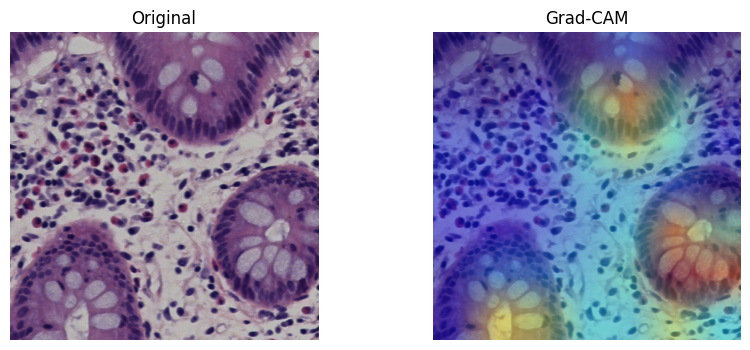

In [145]:
# load image
def load_img(path, transform):
    img = Image.open(path).convert("RGB")
    raw = np.array(img)
    tensor = transform(img).unsqueeze(0)
    return raw, tensor

# choose any test sample
path = "DATASET/test/535953-IMG005x007-1.JPG"
raw_img, tensor_img = load_img(path, test_transform)
tensor_img = tensor_img.to(device)

# run gradcam
gc = GradCAM(model)
cam = gc.generate(tensor_img)

# overlay
overlay_img = overlay_heatmap(raw_img, cam)

# show results
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(raw_img)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Grad-CAM")
plt.imshow(overlay_img)
plt.axis("off")

plt.show()
